# 预载入

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive')
import argparse
import time
import os
import numpy as np
import random
import torch
import RUL.MutiSource.model_mfsan2 as model_mfsan
import RUL.MutiSource.data_loader as data_loader
import RUL.MutiSource.data_loaderr as data_loaderr
from RUL.MutiSource.utils import get_free_gpu, weight_init, weight_init2, log_in_file, visualize_total_loss, save_model,score_cal,rmse_cal,load_model
import math
from torch.autograd import Variable
import torch.nn.functional as F
import RUL.MutiSource.utils as utils
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import torchvision.datasets as datasets
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms
import torch
import logging
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import datetime
# !pip install tensorboard
import RUL.MutiSource.data_loader_cluster as data_loader_cluster
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0] #矩阵行数

    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#path
# current_dir = "/content/drive/MyDrive/RUL"
# train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
# test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
# RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
# FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

# train_FD002_path = current_dir +'/cmapss/train_FD002.csv'
# test_FD002_path = current_dir +'/cmapss/test_FD002.csv'
# RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
# FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

# train_FD003_path = current_dir +'/cmapss/train_FD003.csv'
# test_FD003_path = current_dir +'/cmapss/test_FD003.csv'
# RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
# FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

# train_FD004_path =current_dir +'/cmapss/train_FD004.csv'
# test_FD004_path = current_dir +'/cmapss/test_FD004.csv'
# RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
# FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]
current_dir = "/content/drive/MyDrive/RUL"
train_FD001_path = current_dir +'/cmapss/train_FD001_cluster.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001_cluster.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

train_FD002_path = current_dir +'/cmapss/train_FD002_cluster.csv'
test_FD002_path = current_dir +'/cmapss/test_FD002_cluster.csv'
RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

train_FD003_path = current_dir +'/cmapss/train_FD003_cluster.csv'
test_FD003_path = current_dir +'/cmapss/test_FD003_cluster.csv'
RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

train_FD004_path =current_dir +'/cmapss/train_FD004_cluster.csv'
test_FD004_path = current_dir +'/cmapss/test_FD004_cluster.csv'
RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]

## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']

## Read csv file to pandas dataframe
FD_path = ["none", FD001_path, FD002_path, FD003_path, FD004_path]
FD_name = ["none", "FD001", "FD002", "FD003", "FD004"]



sensor_drop = ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

source_path = ["none", FD_path[1], FD_path[2], FD_path[3], FD_path[4]]  #此处选择source 数据集 1 2 3 分别对应FD001-FD004
target_path = ["none", FD_path[1], FD_path[2], FD_path[3], FD_path[4]]
datasetset_name = ["none", "FD001", "FD002", "FD003", "FD004"]




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 重要参数设置

In [ ]:
# Training settings
sequence_length = 30
batch_size = 512
epochs = 500
lr = [0.001, 0.001,0.005]
momentum = 0.9
cuda = True
seed = 9
log_interval = 5
l2_decay = 1e-3
# optimizer = 'SGD'
optimizer = 'Adam'
len_setting = 'max_len'
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [ ]:
source_chosen = ['None',3,4]
target_chosen = ['None',2]


source1_name = datasetset_name[source_chosen[1]]
source2_name = datasetset_name[source_chosen[2]]
# source3_name = datasetset_name[source_chosen[3]]

target_train_loader = data_loader_cluster.load_training(target_path[target_chosen[1]], sequence_length, sensor_drop,
                                                batch_size)
target_test_loader = data_loader_cluster.load_testing(target_path[target_chosen[1]], sequence_length, sensor_drop,
                                                  batch_size)
target_name = datasetset_name[target_chosen[1]]

# target_test_loaderr = data_loaderr.load_testing(target_path[target_chosen[1]], sequence_length, sensor_drop,
                                                  # batch_size)
# target_train_loaderr = data_loaderr.load_training(target_path[target_chosen[1]], sequence_length, sensor_drop,
                                                # batch_size)
# target_train_loader.dataset[0]

In [ ]:
# for label in target_train_loader.dataset[0]:
#     print(label)

In [ ]:
# for inputs,label in target_train_loaderr:
#     print(inputs,label)

In [ ]:
def train(model):
    global mmd_loss1,mmd_loss2 #全局
    print("--------------------------MFSAN --------------------------------")

    # f_mfsan_train = log_in_file("/mfsan_train_log.log")

    source1_loader = data_loader_cluster.load_training(source_path[source_chosen[1]], sequence_length, sensor_drop,
                                                batch_size)
    source2_loader = data_loader_cluster.load_training(source_path[source_chosen[2]], sequence_length, sensor_drop,
                                                batch_size)
    # source3_loader = data_loader.load_training(source_path[source_chosen[3]], sequence_length, sensor_drop,
    #                                            batch_size)

    source1_len = len(source1_loader)
    source2_len = len(source2_loader)
    # source3_len = len(source3_loader)

    target_len = len(target_train_loader)
    # max_len = max(source1_len,source2_len,source3_len,target_len)
    max_len = max(source1_len,source2_len,target_len)
    # print("111111",source1_len,source2_len,target_len,max_len)

    batch_src1,batch_src2,batch_src3,batch_tar = 0,0,0,0
    running_loss_scr1, running_loss_scr2 ,running_loss_scr3= 0, 0, 0
    running_mmd_loss_scr1, running_mmd_loss_scr2, running_mmd_loss_scr3 = 0, 0, 0
    running_l1_loss_scr1, running_l1_loss_scr2, running_l1_loss_scr3 = 0, 0, 0
    list_src1, list_src2, list_tar = list(enumerate(source1_loader)), list(enumerate(source2_loader)),list(enumerate(target_train_loader))

    optimizer = torch.optim.Adam([
        {'params': model.sharedNet.parameters(), 'lr': lr[1]},

        {'params': model.rul_fc_son1.parameters(), 'lr': lr[1]},
        {'params': model.rul_fc_son2.parameters(), 'lr': lr[1]},

        {'params': model.sonnet1.parameters(), 'lr': lr[1]},
        {'params': model.sonnet2.parameters(), 'lr': lr[1]},

    ], lr=lr[2], weight_decay=l2_decay)



    for batch in range(1, max_len):
        model.train()

        p = (batch - 1) / (max_len)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 #？？？
        optimizer = utils.optimizer_scheduler(optimizer=optimizer, p=p) #Adjust the learning rate of optimizer
        optimizer.zero_grad() #梯度初始化为0

        #####scr1 tgt
        _, (source_data1, source_label1) = list_src1[batch_src1]
        _, (target_data1, _) = list_tar[batch_tar]


        if cuda:
            source_data1, source_label1 = source_data1.cuda(), source_label1.type(torch.FloatTensor).cuda()
            target_data1 = target_data1.cuda()
        source_data1, source_label1 = Variable(source_data1), Variable(source_label1) #tensor不能反向传播，variable可以反向传播
        target_data1 = Variable(target_data1)

        rul_loss1, mmd_loss1, l1_loss1 = model(source_data1, target_data1, source_label1, alpha, mark=1)
        gamma = 2 / (1 + math.exp(-10 * (batch) / (max_len))) - 1

        loss1 = rul_loss1 + gamma * (mmd_loss1 + l1_loss1)
        loss1.backward()
        optimizer.step()
        running_loss_scr1 += loss1.item() #loss为什么要加item() 直接输出的话数据类型是Variable,
        running_mmd_loss_scr1 += mmd_loss1.item()
        running_l1_loss_scr1 += l1_loss1.item()
        batch_src1 += 1
        if batch_src1 >= len(list_src1)-1:
            batch_src1 = 0

        if batch_tar >= len(list_tar)-1:
            batch_tar = 0

        if batch % log_interval == 0:
            print('Train source1 iter: {} [({:.0f}%)]\tLoss: {:.6f}\tRUL_Loss: {:.6f}\tmmd_Loss: {:.6f}\tl1_Loss: {:.6f}'.format(
                batch, 100. * batch/ max_len, loss1.item(), rul_loss1.item(), mmd_loss1.item(), l1_loss1.item()), file=f_mfsan_train, flush=True)

        # print("batch_src1,batch_tar",batch_src1,batch_tar)

        #####scr2 tgt
        _, (source_data2, source_label2) = list_src2[batch_src2]
        _, (target_data2, _) = list_tar[batch_tar]

        if cuda:
            source_data2, source_label2 = source_data2.cuda(), source_label2.type(torch.FloatTensor).cuda()
            target_data2 = target_data2.cuda()
        source_data2, source_label2 = Variable(source_data2), Variable(source_label2)
        target_data2 = Variable(target_data2)
        optimizer.zero_grad()

        rul_loss2, mmd_loss2, l1_loss2 = model(source_data2, target_data2, source_label2, alpha, mark=2)
        gamma = 2 / (1 + math.exp(-10 * (batch) / (max_len))) - 1
        loss2 = rul_loss2 + gamma * (mmd_loss2 + l1_loss2)
        loss2.backward()
        optimizer.step()
        running_loss_scr2 += loss2.item()
        running_mmd_loss_scr2 += mmd_loss2.item()
        running_l1_loss_scr2 += l1_loss2.item()
        batch_src2 += 1
        if batch_src2 >= len(list_src2)-1:
            batch_src2 = 0


        if batch_tar >= len(list_tar)-1:
            batch_tar = 0
        # print("batch_src2,batch_tar", batch_src2, batch_tar)

        if batch % log_interval == 0:
            print(
                'Train source2 iter: {} [({:.0f}%)]\tLoss: {:.6f}\tRUL_Loss: {:.6f}\tmmd_Loss: {:.6f}\tl1_Loss: {:.6f}'.format(
                    batch, 100. * batch / max_len, loss2.item(), rul_loss2.item(), mmd_loss2.item(), l1_loss2.item()), file=f_mfsan_train, flush=True)

        # #####scr3 tgt
        # _, (source_data3, source_label3) = list_src3[batch_src3]
        # _, (target_data3, _) = list_tar[batch_tar]

        # if cuda:
        #     source_data3, source_label3 = source_data3.cuda(), source_label3.type(torch.FloatTensor).cuda()
        #     target_data3 = target_data3.cuda()
        # source_data3, source_label3 = Variable(source_data3), Variable(source_label3)
        # target_data3 = Variable(target_data3)
        # optimizer.zero_grad()

        # rul_loss3, mmd_loss3, l1_loss3 = model(source_data3, target_data3, source_label3, alpha, mark=3)
        # gamma = 2 / (1 + math.exp(-10 * (batch) / (max_len))) - 1
        # loss3 = rul_loss3 + gamma * (mmd_loss3 + l1_loss3)
        # loss3.backward()
        # optimizer.step()
        # running_loss_scr3 += loss3.item()
        # running_mmd_loss_scr3 += mmd_loss3.item()
        # running_l1_loss_scr3 += l1_loss3.item()
        # batch_src3 += 1
        # if batch_src3 >= len(list_src3) - 1:
        #     batch_src3 = 0

        # batch_tar += 1
        # if batch_tar >= len(list_tar) - 1:
        #     batch_tar = 0
        # # print("batch_src2,batch_tar", batch_src2, batch_tar)

        # if batch % log_interval == 0:
        #     print(
        #         'Train source3 iter: {} [({:.0f}%)]\tLoss: {:.6f}\tRUL_Loss: {:.6f}\tmmd_Loss: {:.6f}\tl1_Loss: {:.6f}\n\n'.format(
        #             batch, 100. * batch / max_len, loss3.item(), rul_loss3.item(), mmd_loss3.item(), l1_loss3.item()),
        #         file=f_mfsan_train, flush=True)

    f_mfsan_train.close()
    epoch_loss_scr1 = running_loss_scr1 / (max_len - 1)
    epoch_loss_scr2 = running_loss_scr2 / (max_len - 1)
    # epoch_loss_scr3 = running_loss_scr3 / (max_len - 1)
    epoch_mmd_loss_scr1 = running_mmd_loss_scr1 / (max_len - 1)
    epoch_mmd_loss_scr2 = running_mmd_loss_scr2 / (max_len - 1)
    # epoch_mmd_loss_scr3 = running_mmd_loss_scr3 / (max_len - 1)
    epoch_l1_loss_scr1 = running_l1_loss_scr1 / (max_len - 1)
    epoch_l1_loss_scr2 = running_l1_loss_scr2 / (max_len - 1)
    # epoch_l1_loss_scr3 = running_l1_loss_scr3 / (max_len - 1)

    return epoch_loss_scr1, epoch_loss_scr2,epoch_mmd_loss_scr1, epoch_mmd_loss_scr2, epoch_l1_loss_scr1, epoch_l1_loss_scr2


def test(model):
    model.eval()

    # f_mfsan_test = log_in_file("/mfsan_test_log.log")

    with torch.no_grad():
        for data, target in target_test_loader:
            if cuda:
                data, target = data.cuda(), target.type(torch.FloatTensor).cuda()
            data, target = Variable(data), Variable(target)
            pred1, pred2 = model(data)

            pred1, pred2 =pred1.detach().cpu().numpy().squeeze(1), pred2.detach().cpu().numpy().squeeze(1)
            target = target.detach().cpu().numpy()

            rmse1 = rmse_cal(pred1, target)  # sum up batch loss
            score1 = score_cal(pred1, target)
            rmse2 = rmse_cal(pred2, target) # sum up batch loss
            score2 = score_cal(pred2, target)
            # rmse3 = rmse_cal(pred3, target)  # sum up batch loss
            # score3 = score_cal(pred3, target)
            # w1 = (mmd_loss1-0.5) ** (-2)
            # w2 = (mmd_loss2-0.5) ** (-2)
            # w3 = (mmd_loss3-0.5) ** (-2)
            # w1 = mmd_loss1 ** (-1)
            # w2 = mmd_loss2 ** (-1)
            # w3 = mmd_loss3 ** (-1)
            #w1 = mmd_loss1
            #w2 = mmd_loss2
            #w3 = mmd_loss3
            # w1 = w1.cpu().numpy()
            # w2 = w2.cpu().numpy()
            # w3 = w3.cpu().numpy()
            # ws=w1+w2+w3

            # pred = (w1*pred1 + w2*pred2 + w3*pred3) / ws
            pred=(pred1+pred2)/2
            rmse = rmse_cal(pred, target) # sum up batch loss
            score = score_cal(pred, target)



        print('multi_rmse: {:.4f}, multi_score: {:.4f}'.format(rmse, score), file=f_mfsan_test, flush=True)
        print('source1 rmse {:.4f}, source2 rmse {:.4f}'.format(rmse1, rmse2), file=f_mfsan_test, flush=True)
        print('source1 score {:.4f}, source2 score {:.4f}\n'.format(score1, score2), file=f_mfsan_test, flush=True)
       # print('source1 w {:.4f}, source2 w {:.4f}, source3 w {:.4f}\n\n'.format(w1,w2,w3))
    return rmse, score,rmse1,score1,rmse2,score2,pred1, pred2, pred,target

MFSAN(
  (sharedNet): CFE(
    (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 64, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 128, kernel_size=(2,), stride=(1,), bias=False)
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (sonnet1): DFE(
    (rnn): LSTM(128, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (sonnet2): DFE(
    (rnn): LSTM(128, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (rul_fc_son1): Linear(in_features=199, out_features=1, bias=True)
  (rul_fc_son2): Linear(in_features=199, out_features=1, bias=True)
  (avgpool):

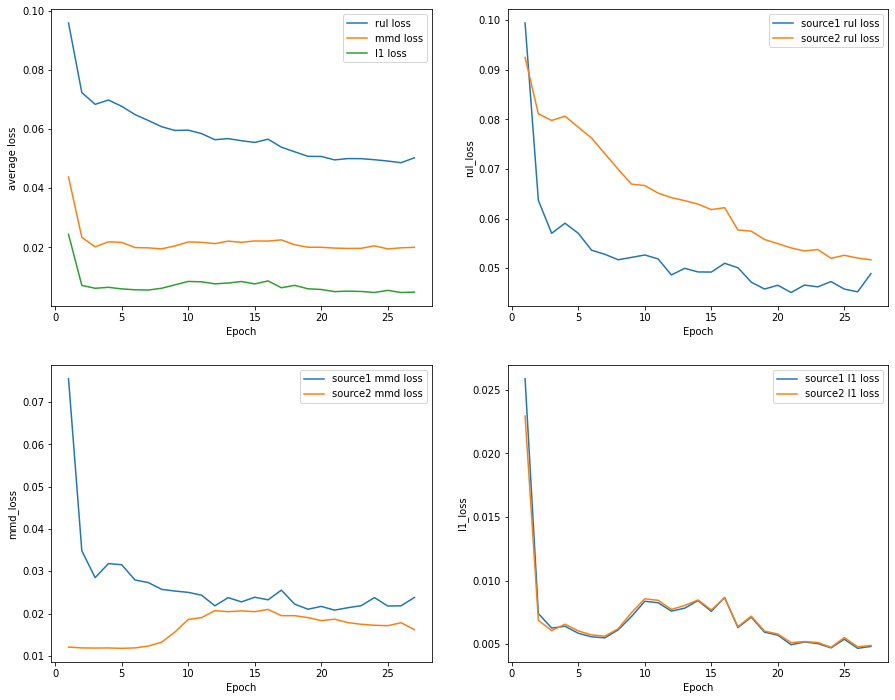

In [ ]:
early_stopper = EarlyStopper(patience=20, min_delta=0.01)
rmse, score = 1000.,0
s1_rmse, s1_score, s2_rmse, s2_score = 0,0,0,0
history = {}
history['epoch'] = []
history['total_rul_loss'] = []
history['total_mmd_loss'] = []
history['total_l1_loss'] = []
history['epoch_loss_scr1'] = []
history['epoch_loss_scr2'] = []
# history['epoch_loss_scr3'] = []
history['epoch_mmd_loss_scr1'] = []
history['epoch_mmd_loss_scr2'] = []
# history['epoch_mmd_loss_scr3'] = []
history['epoch_l1_loss_scr1'] = []
history['epoch_l1_loss_scr2'] = []
# history['epoch_l1_loss_scr3'] = []
history['test_rmse'] = []
history['test_score'] = []
history['s1_rmse'] = []
history['s1_score'] = []
history['s2_rmse'] = []
history['s2_score'] = []
# history['s3_rmse'] = []
# history['s3_score'] = []
history['pred1'] = []
history['pred2'] = []
# history['pred3'] = []
history['pred'] = []
history['target'] = []
# 获取当前的日期和时间
now = str(datetime.datetime.now())
model = model_mfsan.MFSAN().apply(weight_init)
print(model)
if cuda:
    model.cuda()


f_mfsan_train = log_in_file('/'+target_name+'_'+now+'_train.log')
f_mfsan_test = log_in_file('/'+target_name+'_'+now+'_test.log')
print("当前日期和时间：", now,file=f_mfsan_train, flush=True)
print('training settings:\t','lr:',lr,'momentum:',momentum,'l2_decay:',l2_decay,'optimizer:',optimizer,'len_setting:',len_setting,file=f_mfsan_train, flush=True)
print('model architecture:\n',model,file=f_mfsan_train, flush=True)
print(source1_name, source2_name , "to", target_name,file=f_mfsan_train, flush=True)
print("当前日期和时间：", now,file=f_mfsan_test, flush=True)
print('training settings:\t','lr:',lr,'momentum:',momentum,'l2_decay:',l2_decay,'optimizer:',optimizer,'len_setting:',len_setting,file=f_mfsan_test, flush=True)
print('model architecture:\n',model,file=f_mfsan_test, flush=True)
print(source1_name, source2_name , "to", target_name,file=f_mfsan_test, flush=True)

for epoch in range(1,epochs+1):
    ### train phase
    f_mfsan_train = log_in_file('/'+target_name+'_'+now+'_train.log')
    print('Train epochs:{:.6f}\t'.format(epoch), file=f_mfsan_train, flush=True)
    epoch_loss_scr1,epoch_loss_scr2,epoch_mmd_loss_scr1,epoch_mmd_loss_scr2,epoch_l1_loss_scr1,epoch_l1_loss_scr2 = train(model)
    history['epoch'].append(epoch)

    history['total_rul_loss'].append((epoch_loss_scr1+epoch_loss_scr2) / 2)
    history['total_mmd_loss'].append((epoch_mmd_loss_scr1+epoch_mmd_loss_scr2) / 2)
    history['total_l1_loss'].append((epoch_l1_loss_scr1+epoch_l1_loss_scr2) / 2)

    history['epoch_loss_scr1'].append(epoch_loss_scr1)
    history['epoch_loss_scr2'].append(epoch_loss_scr2)
    # history['epoch_loss_scr3'].append(epoch_loss_scr3)
    history['epoch_mmd_loss_scr1'].append(epoch_mmd_loss_scr1)
    history['epoch_mmd_loss_scr2'].append(epoch_mmd_loss_scr2)
    # history['epoch_mmd_loss_scr3'].append(epoch_mmd_loss_scr3)
    history['epoch_l1_loss_scr1'].append(epoch_l1_loss_scr1)
    history['epoch_l1_loss_scr2'].append(epoch_l1_loss_scr2)
    # history['epoch_l1_loss_scr3'].append(epoch_l1_loss_scr3)
    print('Train result: Epoch: {}/{}\tepoch_loss_scr1: {:.4f} epoch_loss_scr2: {:.4f}'.format(epoch, epochs, epoch_loss_scr1,epoch_loss_scr2))

    ### test phase
    f_mfsan_test = log_in_file('/'+target_name+'_'+now+'_test.log')
    t_rmse, t_score, t_s1_rmse, t_s1_score, t_s2_rmse, t_s2_score, pred1, pred2, pred, target = test(model)
    history['test_rmse'].append(t_rmse)
    history['test_score'].append(t_score)
    history['s1_rmse'].append(t_s1_rmse)
    history['s1_score'].append(t_s1_score)
    history['s2_rmse'].append(t_s2_rmse)
    history['s2_score'].append(t_s2_score)
    history['pred1'].append(pred1)
    history['pred2'].append(pred2)
    history['pred'].append(pred)
    history['target'].append(target)

    if t_rmse < rmse:
        rmse = t_rmse
        score = t_score
        s1_rmse, s1_score, s2_rmse, s2_score = t_s1_rmse, t_s1_score, t_s2_rmse, t_s2_score

        save_model(model, 'mfsan')

    print("Test result: ", "best rmse: %.6f best rmse's score: %.6f" % (rmse, score))
    print("best s1 mse: %.6f s1 score: %.6f s2 mse: %.6f s2 score: %.6f" % (s1_rmse, s1_score,s2_rmse,s2_score), "\n")

    if early_stopper.early_stop(t_rmse):
        print('Early Stop！')
        break

# Generate the figure
fig = plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('average loss')
plt.plot(history['epoch'], np.array(history['total_rul_loss']), label='rul loss')
plt.plot(history['epoch'], np.array(history['total_mmd_loss']), label='mmd loss')
plt.plot(history['epoch'], np.array(history['total_l1_loss']), label='l1 loss')
plt.legend()


plt.subplot(2, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('rul_loss')
plt.plot(history['epoch'], np.array(history['epoch_loss_scr1']), label='source1 rul loss')
plt.plot(history['epoch'], np.array(history['epoch_loss_scr2']), label='source2 rul loss')
# plt.plot(history['epoch'], np.array(history['epoch_rul_loss_scr3']), label='source3 rul loss')
plt.legend()

# mmd loss visualize
plt.subplot(2, 2, 3)
plt.xlabel('Epoch')
plt.ylabel('mmd_loss')
plt.plot(history['epoch'], np.array(history['epoch_mmd_loss_scr1']), label='source1 mmd loss')
plt.plot(history['epoch'], np.array(history['epoch_mmd_loss_scr2']), label='source2 mmd loss')
# plt.plot(history['epoch'], np.array(history['epoch_mmd_loss_scr3']), label='source3 mmd loss')
plt.legend()

#l1 loss visuliza
plt.subplot(2, 2, 4)
plt.xlabel('Epoch')
plt.ylabel('l1_loss')
plt.plot(history['epoch'], np.array(history['epoch_l1_loss_scr1']), label='source1 l1 loss')
plt.plot(history['epoch'], np.array(history['epoch_l1_loss_scr2']), label='source2 l1 loss')
# plt.plot(history['epoch'], np.array(history['epoch_l1_loss_scr3']), label='source3 l1 loss')
plt.legend()
print("ALL is finished!!!")
print("Test result: ", "best rmse: %.6f best rmse's score: %.6f" % (rmse, score),file=f_mfsan_test, flush=True)
print("best s1 mse: %.6f s1 score: %.6f s2 mse: %.6f s2 score: %.6f" % (s1_rmse, s1_score,s2_rmse,s2_score),file=f_mfsan_test, flush=True)

# Save the plots to a file
plt.savefig(current_dir+'/MutiSource/plots/'+now+"_target_"+target_name+'.png')


ALL is finished!!!


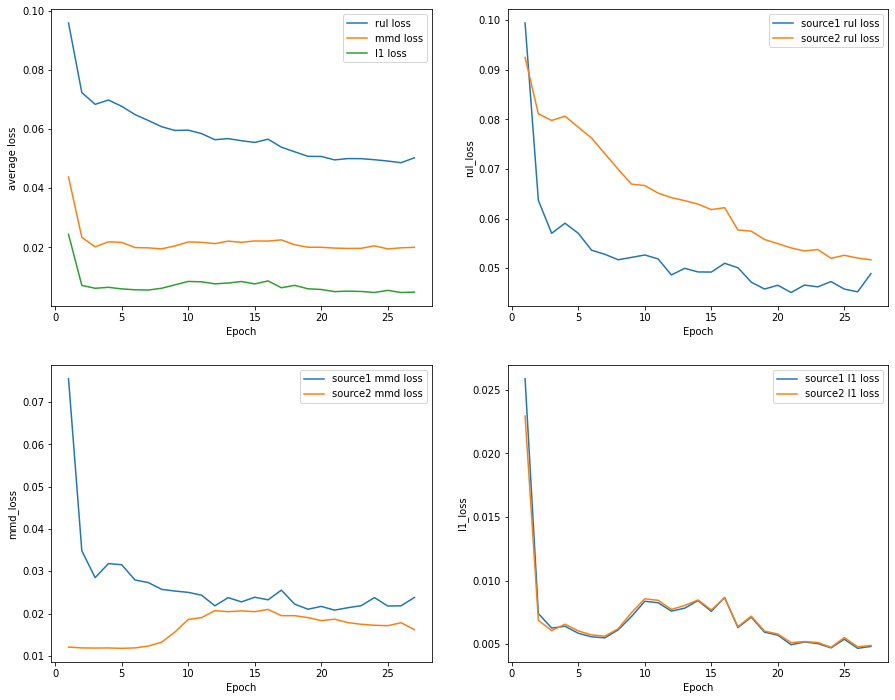

In [ ]:
# Generate the figure
fig = plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('average loss')
plt.plot(history['epoch'], np.array(history['total_rul_loss']), label='rul loss')
plt.plot(history['epoch'], np.array(history['total_mmd_loss']), label='mmd loss')
plt.plot(history['epoch'], np.array(history['total_l1_loss']), label='l1 loss')
plt.legend()


plt.subplot(2, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('rul_loss')
plt.plot(history['epoch'], np.array(history['epoch_loss_scr1']), label='source1 rul loss')
plt.plot(history['epoch'], np.array(history['epoch_loss_scr2']), label='source2 rul loss')
# plt.plot(history['epoch'], np.array(history['epoch_rul_loss_scr3']), label='source3 rul loss')
plt.legend()

# mmd loss visualize
plt.subplot(2, 2, 3)
plt.xlabel('Epoch')
plt.ylabel('mmd_loss')
plt.plot(history['epoch'], np.array(history['epoch_mmd_loss_scr1']), label='source1 mmd loss')
plt.plot(history['epoch'], np.array(history['epoch_mmd_loss_scr2']), label='source2 mmd loss')
# plt.plot(history['epoch'], np.array(history['epoch_mmd_loss_scr3']), label='source3 mmd loss')
plt.legend()

#l1 loss visuliza
plt.subplot(2, 2, 4)
plt.xlabel('Epoch')
plt.ylabel('l1_loss')
plt.plot(history['epoch'], np.array(history['epoch_l1_loss_scr1']), label='source1 l1 loss')
plt.plot(history['epoch'], np.array(history['epoch_l1_loss_scr2']), label='source2 l1 loss')
# plt.plot(history['epoch'], np.array(history['epoch_l1_loss_scr3']), label='source3 l1 loss')
plt.legend()
print("ALL is finished!!!")
print("Test result: ", "best rmse: %.6f best rmse's score: %.6f" % (rmse, score),file=f_mfsan_test, flush=True)
print("best s1 mse: %.6f s1 score: %.6f s2 mse: %.6f s2 score: %.6f" % (s1_rmse, s1_score,s2_rmse,s2_score),file=f_mfsan_test, flush=True)

# Save the plots to a file
plt.savefig(current_dir+'/MutiSource/plots/'+now+"_target_"+target_name+'.png')

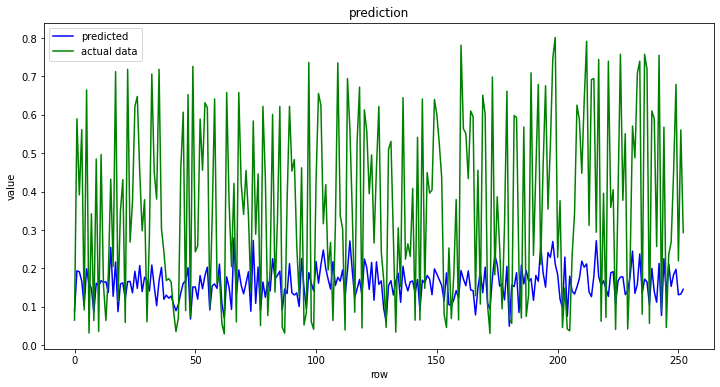

In [ ]:
fig_verify = plt.figure(figsize=(12, 6))
plt.plot(pred, color="blue")
plt.plot(target, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.savefig(current_dir+'/MutiSource/plots/'+now+"_target_"+target_name+'_test_result.png')

In [ ]:
rmse1 = rmse_cal(pred, target)  # sum up batch loss
print(rmse1)
score1 = score_cal(pred, target)
print(score1)

36.809834
9366.261941021245
